Code to preprocess Stereo .gef data to specifically set the bin size before saving it as an .h5ad object for further downstream analysis in R and Seurat. Before starting, set the kernel to the "st" kernel allowing to run Stereopy package. The script is also ment to be runned on the in-house Deng-server or similar HPC environment.

The script and pre-processing analysis is performed on one sample at the time. Therefore, the path to the specific .gef file has to be manually changed below.

In [72]:
#import stereo as st
#import warnings

import sys
import stereo as st
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

Sanity check to see if Stereopy is loaded and what version it is

In [73]:
st.__version__

'1.1.0'

Vector are generated including key marker genes and genes of interest

In [74]:
epithelium_subtype = ['PTGS1', 'VTCN1', 'SLC26A7', 'LGR5', 'KRT5', 'WNT7A', 'CPM', 'IHH', 'EMID1', 'PPARG', 'C2CD4A', 'SLC18A2',
                     'PAEP', 'CXCL14', 'MKI67', 'HMGB2', 'AR', 'CDC20B', 'CCNO', 'HES6']
stroma_subtype = ['ESR1', 'PGR', 'IGF1', 'ECM1', 'PAEP', 'OGN', 'TOP2A', 'MKI67', 'THY1', 'COL1A1', 'PCOLCE', 'C7', 'ACTA2', 'ACTG2', 'MCAM']
all_marker_genes = ['EPCAM', 'CPM', 'LGR5', 
                    'IGF1', 'DCN', 'COL6A1', 
                   'GUCY1A2', 'ACTA2', 'NOTCH3',
                   'CD14', 'CSF1R', 'LYZ',
                   'STK17B', 'NCAM1', 'CCL5', 'CD2',
                   'PCDH17', 'VWF',
                   'PROX1', 'FLT4']
print(epithelium_subtype)
print(stroma_subtype)
print(all_marker_genes)

['PTGS1', 'VTCN1', 'SLC26A7', 'LGR5', 'KRT5', 'WNT7A', 'CPM', 'IHH', 'EMID1', 'PPARG', 'C2CD4A', 'SLC18A2', 'PAEP', 'CXCL14', 'MKI67', 'HMGB2', 'AR', 'CDC20B', 'CCNO', 'HES6']
['ESR1', 'PGR', 'IGF1', 'ECM1', 'PAEP', 'OGN', 'TOP2A', 'MKI67', 'THY1', 'COL1A1', 'PCOLCE', 'C7', 'ACTA2', 'ACTG2', 'MCAM']
['EPCAM', 'CPM', 'LGR5', 'IGF1', 'DCN', 'COL6A1', 'GUCY1A2', 'ACTA2', 'NOTCH3', 'CD14', 'CSF1R', 'LYZ', 'STK17B', 'NCAM1', 'CCL5', 'CD2', 'PCDH17', 'VWF', 'PROX1', 'FLT4']


## Loading the data
Current paths and files to be processed are:  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C01828D2_004_0_LS/01.StandardWorkflow_Result/GeneExpMatrix/C01828D2.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C01829D6_004_16/01.StandardWorkflow_Result/GeneExpMatrix/C01829D6.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02132D4_204/01.StandardWorkflow_Result/GeneExpMatrix/C02132D4.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02132D6_027_0_LS/01.StandardWorkflow_Result/GeneExpMatrix/C02132D6.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02132E3_208/01.StandardWorkflow_Result/GeneExpMatrix/C02132E3.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02133D4_220/01.StandardWorkflow_Result/GeneExpMatrix/C02133D4.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02133D5_031_0_Met/01.StandardWorkflow_Result/GeneExpMatrix/C02133D5.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02133E3_027_16_LS/01.StandardWorkflow_Result/GeneExpMatrix/C02133E3.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02133E4_212/01.StandardWorkflow_Result/GeneExpMatrix/C02133E4.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02134C2_005_0_Met/01.StandardWorkflow_Result/GeneExpMatrix/C02134C2.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02134C5_005_16_Met/01.StandardWorkflow_Result/GeneExpMatrix/C02134C5.tissue.gef  
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02134C6_031_16_Met/01.StandardWorkflow_Result/GeneExpMatrix/C02134C6.tissue.gef

## Selected samples are the following:
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02132E3_208/01.StandardWorkflow_Result/GeneExpMatrix/C02132E3.tissue.gef
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02133D4_220/01.StandardWorkflow_Result/GeneExpMatrix/C02133D4.tissue.gef
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02132D6_027_0_LS/01.StandardWorkflow_Result/GeneExpMatrix/C02132D6.tissue.gef
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02133E3_027_16_LS/01.StandardWorkflow_Result/GeneExpMatrix/C02133E3.tissue.gef
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02133D5_031_0_Met/01.StandardWorkflow_Result/GeneExpMatrix/C02133D5.tissue.gef
./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02134C6_031_16_Met/01.StandardWorkflow_Result/GeneExpMatrix/C02134C6.tissue.gef

Setting the path below with above paths

In [75]:
data_path = './Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02132D6_027_0_LS/01.StandardWorkflow_Result/GeneExpMatrix/C02132D6.tissue.gef'
st.io.read_gef_info(data_path)
output_bin = './Output/0_Preprocessing_filtered_bin30/C02132D6_027_0_LS_bin30.h5ad'
output_log2 = './Output/0_Preprocessing_bin30_filtered_log2/C02132D6_027_0_LS_bin30_log2.h5ad'
output_SCT = './Output/0_Preprocessing_bin30_filtered_SCT/C02132D6_027_0_LS_bin30_SCT.h5ad'
output_ann = './Output/0_Preprocessing_bin30_filtered_SCT_Ann/C02132D6_027_0_LS_bin30_SCT_Ann.h5ad'

[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1317][INFO]: This is GEF file which contains traditional bin infomation.
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1318][INFO]: bin_type: bins
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1321][INFO]: Bin size list: ['bin1']
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1327][INFO]: Resolution: 500
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1330][INFO]: Gene count: 38476
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1339][INFO]: offsetX: 0
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1342][INFO]: offsetY: 0
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1345][INFO]: Width: 19385
[2024-04-30 14:56:37][Stereo][627410][MainThread][140223960068480][reader][1348][INFO]: Height: 21706
[2024-04-30 14:56:37][Ster

Load the data and generate a StereoExpData object

In [76]:
data = st.io.read_gef(file_path=data_path, bin_size=30)

# simply type the varibale to get related information
data

[2024-04-30 14:56:44][Stereo][627410][MainThread][140223960068480][reader][1070][INFO]: read_gef begin ...
[2024-04-30 14:56:47][Stereo][627410][MainThread][140223960068480][reader][1241][INFO]: the matrix has 17464 cells, and 38476 genes.
[2024-04-30 14:56:47][Stereo][627410][MainThread][140223960068480][reader][1242][INFO]: read_gef end.


path:./Data/Endometrium_StereoSeq_Spatial_preprocessed_data_230831/C02132D6_027_0_LS/01.StandardWorkflow_Result/GeneExpMatrix/C02132D6.tissue.gef bin:30
               generateBinInfo - 3.351504 cpu sec


StereoExpData object with n_cells X n_genes = 17464 X 38476
bin_type: bins
bin_size: 30
offset_x = 0
offset_y = 0
cells: ['cell_name']
genes: ['gene_name']
result: []

## Quality Control of non-normalised data
Generate basic QC measures such as total counts per bin, genes by count and mitochondria percentage. Stomics describes it as:  

total_counts - the total counts per cell;

n_genes_by_counts - the number of genes expressed in count maxtrix;

pct_countss_mt - the percentage of counts in mitochondrial genes.

[2024-04-30 14:56:47][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run cal_qc...
[2024-04-30 14:56:47][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: cal_qc end, consume time 0.1059s.


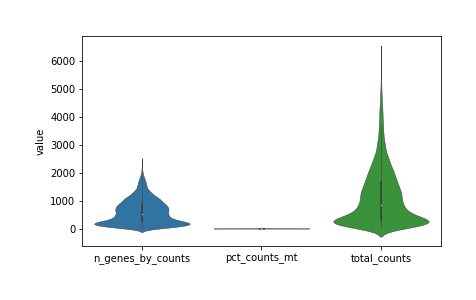

In [77]:
data.tl.cal_qc()
data.plt.violin()

Project the QC data on the spatial scatter

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

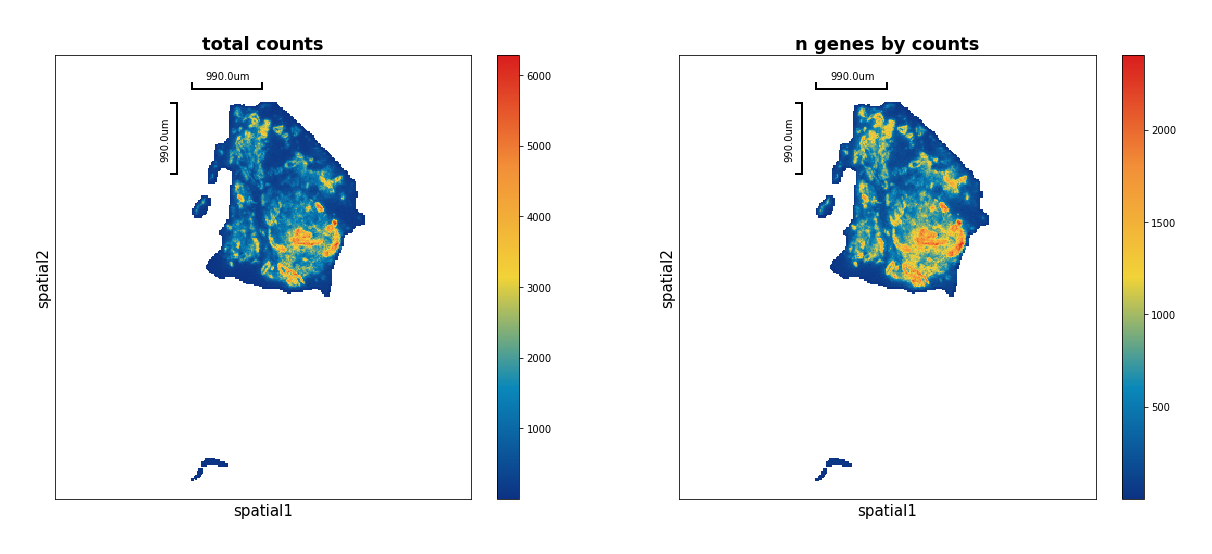

In [78]:
data.plt.spatial_scatter()

## Filtering the non-normalised data
Stereopy works with three methods to filter the data:  
data.tl.filter_cells, data.tl.filter_genes, data.tl.filter_coordinates.

The data can therefore be filtered based on three different levels; cell, gene and coordinate where a bin unit could be treated as a made-up cell provisionally.

We filter bin units (bin_size is set to 50 at the beginning of our example) based on quality control indicators which have been calculated in QC part. Beforehand, observe the distribution of cells according to scatter plots.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

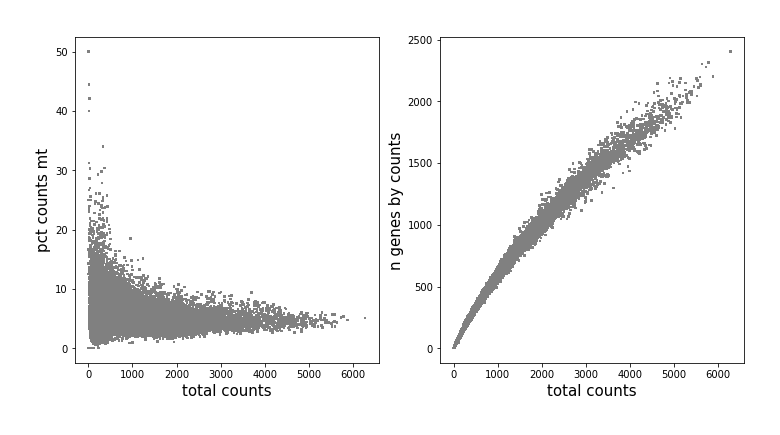

In [79]:
data.plt.genes_count()

We filter away bins with >20% mitochondria and with few counts and genes expressed.

[2024-04-30 14:57:02][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run filter_cells...
[2024-04-30 14:57:02][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: filter_cells end, consume time 0.0915s.
[2024-04-30 14:57:02][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run cal_qc...
[2024-04-30 14:57:02][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: cal_qc end, consume time 0.0969s.


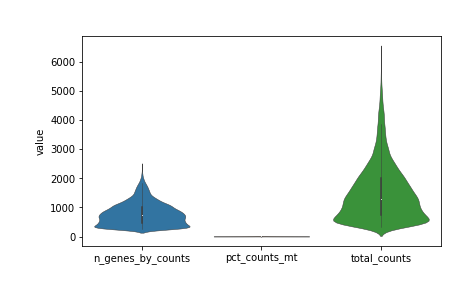

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

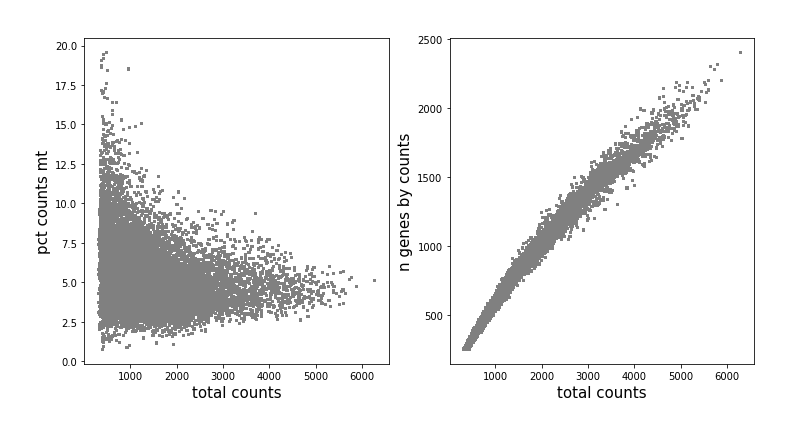

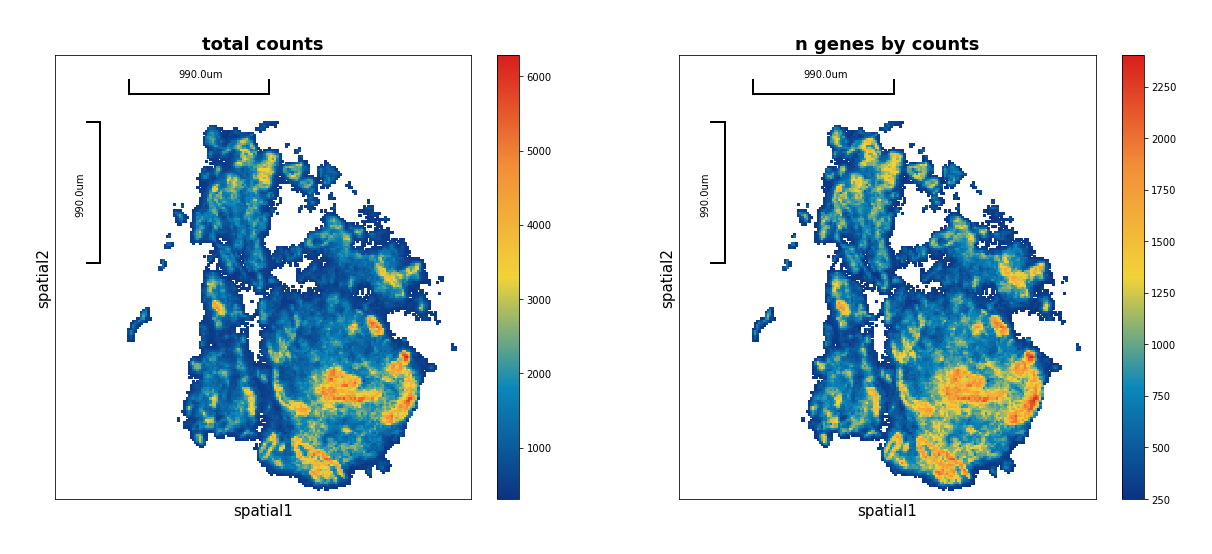

In [80]:
data.tl.filter_cells(
        min_gene=20,
        min_n_genes_by_counts=250,
        pct_counts_mt=20,
        inplace=True
        )
data
data.tl.cal_qc()
data.plt.violin()
data.plt.genes_count()
data.plt.spatial_scatter()

Checkpoint to save the raw data to be able to redo the filtering

In [81]:
data.tl.raw_checkpoint()
data.tl.raw

StereoExpData object with n_cells X n_genes = 12472 X 38476
bin_type: bins
bin_size: 30
offset_x = 0
offset_y = 0
cells: ['cell_name', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt']
genes: ['gene_name', 'n_cells', 'n_counts', 'mean_umi']
result: []

To retrieve the raw data, run data.tl.reset_raw_data().

### Saving the binned data
Before normalisation, we save the binned and filtered data.

In [82]:
info = help(st.io.write_h5ad)
print(info)

Help on function write_h5ad in module stereo.io.writer:

write_h5ad(data: stereo.core.stereo_exp_data.StereoExpData, use_raw: bool = True, use_result: bool = True, key_record: dict = None, output: str = None, split_batches: bool = True)
    Write the StereoExpData into a H5ad file.
    
    Parameters
    ---------------------
    data
        the input StereoExpData object.
    use_raw
        whether to save raw data.
    use_result
        whether to save `result` and `res_key`.
    key_record
        a dict includes selective `res_key` with the precondition that `use_result`
        is `True`, if None, it will save the `result` and `res_key` of
        `data.tl.key_record`,otherwise it will save the result and res_key of the dict.
    output
        the path to output file.
    split_batches
        Whether to save each batch to a single file if it is a merged data, default to True.
    Returns
    -------------------
    None

None


In [83]:
st.io.write_h5ad(data, output=output_bin)

[2024-04-30 14:57:18][Stereo][627410][MainThread][140223960068480][data][73][WARNING]: the output file is exists, we will replace it with new file.


## Normalization with Log2, currently not used
We run log2 normalisation to have it in the object. Labelling and annotation is however done with scTransformed counts

In [84]:
info = help(data.tl.raw_checkpoint)

print(info)

Help on method raw_checkpoint in module stereo.core.st_pipeline:

raw_checkpoint() method of stereo.core.st_pipeline.StPipeline instance
    Save current data to `self.raw`. Running this function will be a convinent choice,
    when your data have gone through several steps of basic preprocessing.
    
    Parameters
    -----------------------------
    
    Returns
    -----------------------------
    None

None


In [85]:
info = help(data.tl.reset_raw_data)

print(info)

Help on method reset_raw_data in module stereo.core.st_pipeline:

reset_raw_data() method of stereo.core.st_pipeline.StPipeline instance
    Reset `self.data` to the raw data saved in `self.raw` when you want data
    get raw expression matrix.
    
    :return:

None


In [86]:
info = help(data.tl.normalize_total)
print(info)

Help on method normalize_total in module stereo.core.st_pipeline:

normalize_total(target_sum: int = 10000, inplace: bool = True, res_key: str = 'normalize_total') method of stereo.core.st_pipeline.StPipeline instance
    Normalize total counts over all genes per cell such that each cell has the same
    total count after normalization.
    
    Parameters
    -----------------------
    target_sum
        the number of total counts per cell after normalization, if `None`, each cell has a
        total count equal to the median of total counts for all cells before normalization.
    inplace
        whether to inplcae previous data or get a new express matrix after normalize_total.
    res_key
        the key to get targeted result from `self.result`.
    
    Returns
    ----------------
    An object of StereoExpData.
    Depending on `inplace`, if `True`, the data will be replaced by those normalized

None


In [87]:
info = help(data.tl.log1p)
print(info)

Help on method log1p in module stereo.core.st_pipeline:

log1p(inplace: bool = True, res_key: str = 'log1p') method of stereo.core.st_pipeline.StPipeline instance
    Transform the express matrix logarithmically.
    
    Parameters
    -----------------
    inplace
        whether to inplcae previous data or get a new express matrix after normalization of log1p.
    res_key
        the key to get targeted result from `self.result`.
    
    Returns
    ----------------
    An object of StereoExpData.
    Depending on `inplace`, if `True`, the data will be replaced by those normalized.

None


In [88]:
##data.sparse2array()

##gmean = np.exp(np.log(data.exp_matrix.T + 1).mean(1)) - 1

# preprocessing
##data.tl.raw_checkpoint()
##data.tl.normalize_total(target_sum=1e4)
##data.tl.log1p()

##log_normalize_result = pd.DataFrame([gmean, data.exp_matrix.T.var(1)], index=['gmean', 'log_normalize_variance'], columns=data.gene_names).T

##from stereo.algorithm.sctransform.plotting import plot_log_normalize_var

##fig1=plot_log_normalize_var(log_normalize_result)

Save the log2 normalised object

In [89]:
#st.io.write_h5ad(data, output=output_log2)

## Normalization via scTransform
We proceed with normalizing and clustering with scTransform. The default scTransform settings are used, sampling 5000 cells and 2000 genes for estimating parameters. 

First we perform preprocessing

In [90]:
info = help(data.tl.sctransform)
print(info)

Help on method sctransform in module stereo.core.st_pipeline:

sctransform(n_cells: int = 5000, n_genes: int = 2000, filter_hvgs: bool = True, var_features_n: int = 3000, inplace: bool = True, res_key: str = 'sctransform', exp_matrix_key: str = 'scale.data', seed_use: int = 1448145, filter_raw: Union[bool, NoneType] = True, **kwargs) method of stereo.core.st_pipeline.StPipeline instance
    Normalization of scTransform, refering to Seurat [Hafemeister19]_.
    
    Parameters
    ----------------------
    n_cells
        number of cells to use for estimating parameters.
    n_genes
        number of genes to use for estimating parameters. means all genes.
    filter_hvgs
        True to retain data associated with highly variable genes only while False to entire data.
    var_features_n
        the number of variable features to select, for calculating a subset of pearson residuals.
    inplace
        whether to replace the previous expression data.
    res_key
        the key to get

### Restore the data to raw before scTransformation (after log2 normalisation, however this is not working)

In [91]:
#data.tl.reset_raw_data
#data.tl.raw

[2024-04-30 14:57:31][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run sctransform...
[2024-04-30 14:57:31][Stereo][627410][MainThread][140223960068480][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2024-04-30 14:57:41][Stereo][627410][MainThread][140223960068480][vst][123][INFO]: gene-cell umi shape (27765, 12472), n_genes 2000 n_cells 5000
[2024-04-30 14:58:04][Stereo][627410][MainThread][140223960068480][vst][137][INFO]: get_model_pars finished, cost 20.058101654052734 seconds
[2024-04-30 14:58:07][Stereo][627410][MainThread][140223960068480][vst][307][INFO]: ksmooth finished, cost 0.8197360038757324 seconds
[2024-04-30 14:58:07][Stereo][627410][MainThread][140223960068480][vst][155][INFO]: reg_model_pars finished, cost 2.6811647415161133 seconds
[2024-04-30 14:58:48][Stereo][627410][MainThread][140223960068480][vst][180][INFO]: pearson_residual cost 41.78086042404175 seconds
[2024-04-30 14:59:30][Stereo]

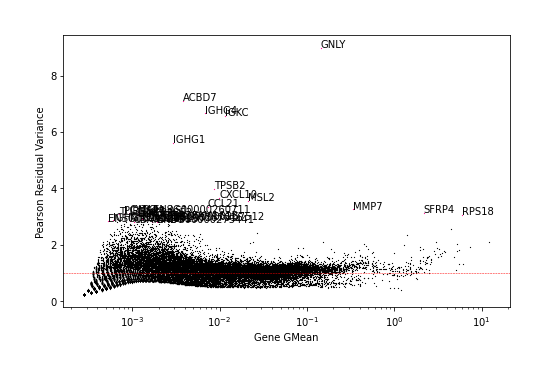

In [92]:
# Preprocessing
#data.tl.sctransform(res_key='sctransform', inplace=False, filter_hvgs=True, n_cells=5000, n_genes=2000)
#data.tl.sctransform(res_key='sctransform', inplace=True, filter_hvgs=False, n_cells=5000, n_genes=2000)
data.tl.sctransform(res_key='sctransform', inplace=False, filter_hvgs=True, n_cells=5000, n_genes=2000)

from stereo.algorithm.sctransform.plotting import plot_residual_var

fig2=plot_residual_var(data.tl.result['sctransform'])

We embed the data and run PCA and UMAP

In [93]:
# Embedding
data.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap', init_pos='spectral', spread=2.0)

[2024-04-30 15:00:48][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run pca...
[2024-04-30 15:00:49][Stereo][627410][MainThread][140223960068480][dim_reduce][85][INFO]: exp_matrix dType is changed to float32
[2024-04-30 15:00:56][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: pca end, consume time 7.4512s.
[2024-04-30 15:00:56][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run neighbors...
[2024-04-30 15:00:57][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: neighbors end, consume time 1.0586s.
[2024-04-30 15:00:57][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run umap...


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


[2024-04-30 15:01:01][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: umap end, consume time 4.1515s.


In [94]:
# Clustering
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

[2024-04-30 15:01:01][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run leiden...
[2024-04-30 15:01:05][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: leiden end, consume time 4.2381s.


Generating a UMAP of the SCT clustering

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

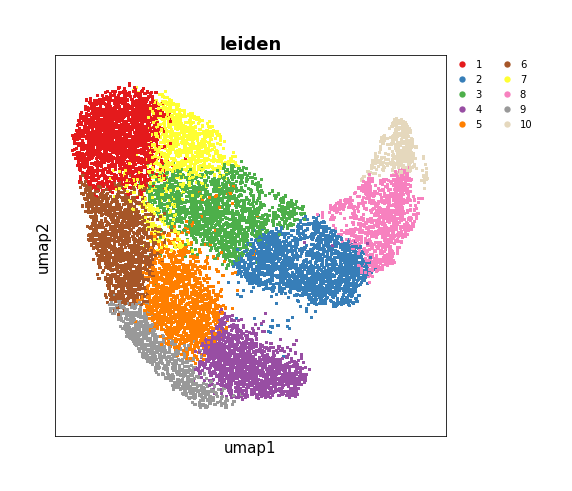

In [95]:
data.plt.umap(res_key='umap', cluster_key='leiden')

We extract the top 50 feature genes

In [96]:
sct_high_genes = data.tl.result['sctransform'][1]['top_features']
sct_high_genes.tolist()[:50]

['GNLY',
 'ACBD7',
 'IGHG4',
 'IGKC',
 'IGHG1',
 'TPSB2',
 'CXCL10',
 'MSL2',
 'CCL21',
 'MMP7',
 'YY2',
 'CYTL1',
 'ENSG00000260711',
 'SFRP4',
 'PGM5P4-AS1',
 'TUBB8P7',
 'RPS18',
 'LINC00853',
 'ACY3',
 'PCDHGA10',
 'KIR2DS4',
 'FAM161B',
 'ENSG00000267512',
 'ENSG00000287016',
 'IGHG3',
 'NFE2L1-DT',
 'ENSG00000289257',
 'OCLNP1',
 'CBARP-DT',
 'ENSG00000275441',
 'ENSG00000254503',
 'RNU6-1016P',
 'CLECL1',
 'C22orf15',
 'LINC01123',
 'ALDH3A1',
 'LINC02202',
 'ENSG00000272024',
 'CCDC152',
 'ENSG00000228318',
 'HMGB3P22',
 'GRPEL2-AS1',
 'ENSG00000289261',
 'TMEM31',
 'ENSG00000265460',
 'TCF21',
 'ENSG00000278231',
 'ENSG00000280339',
 'ENSG00000226849',
 'ENSG00000285018']

## Gene distribution
Investigate how marker genes distribute in the UMAP and spatial dimension.

First, the UMAP distribution

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

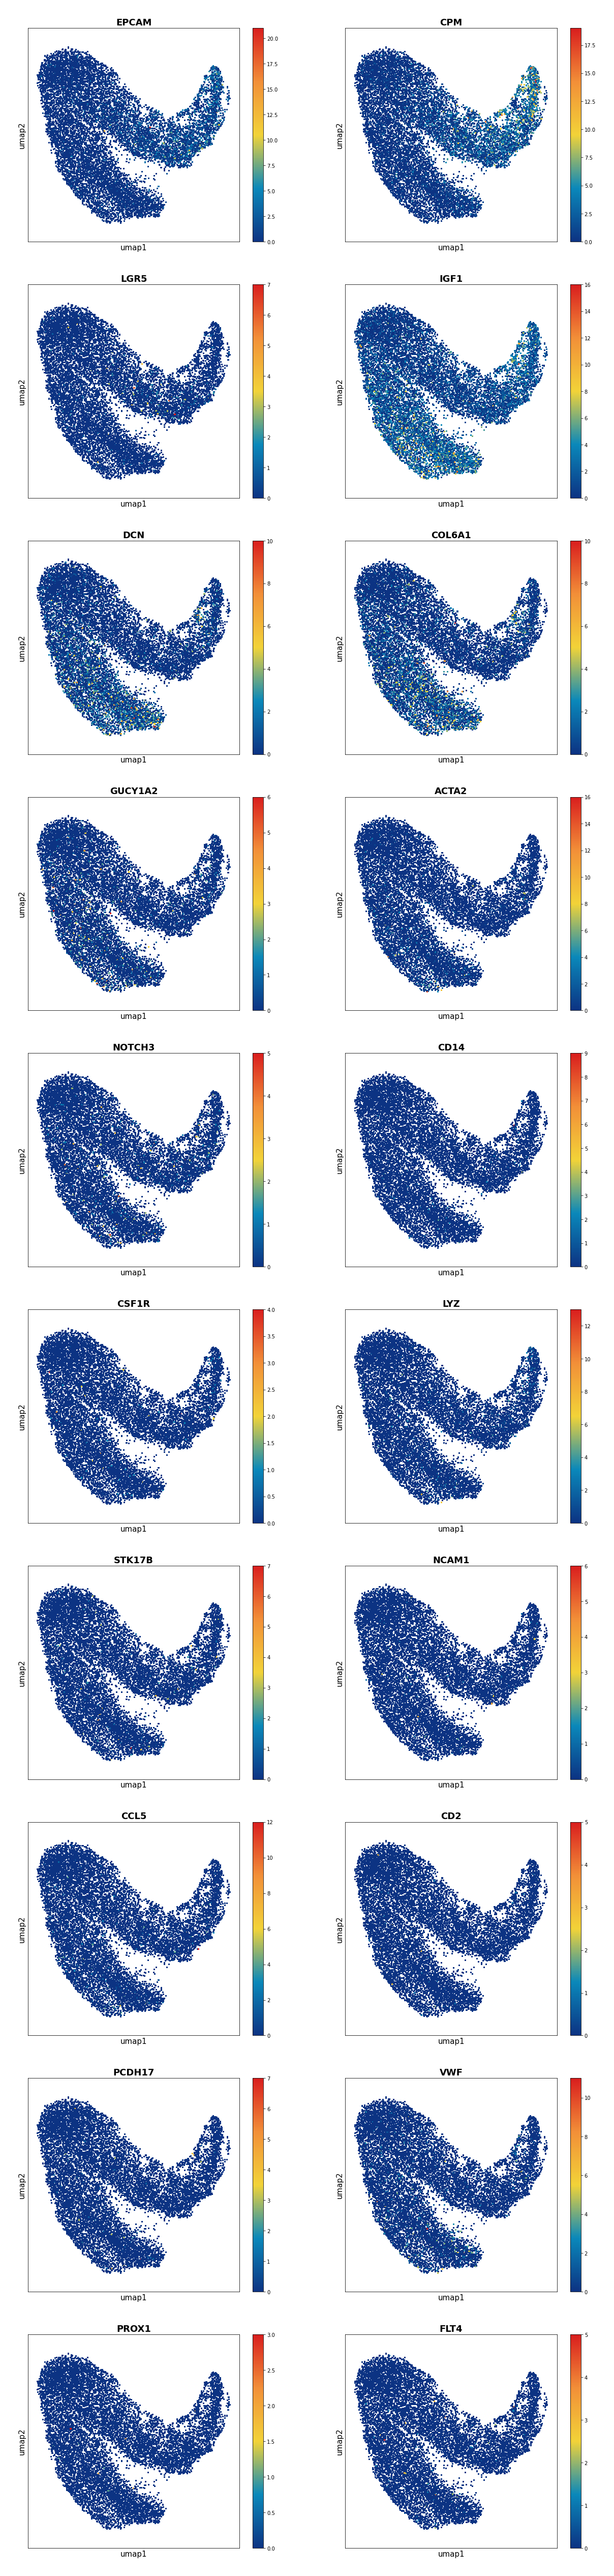

In [97]:
#data.plt.umap(res_key='umap', gene_names=epithelium_genes)
#data.plt.umap(res_key='umap', gene_names=stroma_genes)
data.plt.umap(res_key='umap', gene_names=all_marker_genes)

Checking for the genes in the spatial distribution

Help on method spatial_scatter_by_gene in module stereo.plots.plot_collection:

spatial_scatter_by_gene(gene_name: Union[str, list, numpy.ndarray], dot_size: Union[int, NoneType] = None, palette: Union[str, NoneType] = 'CET_L4', color_bar_reverse: Union[bool, NoneType] = True, width: Union[int, NoneType] = None, height: Union[int, NoneType] = None, x_label: Union[str, NoneType] = 'spatial1', y_label: Union[str, NoneType] = 'spatial2', title: Union[str, NoneType] = None, vmin: float = None, vmax: float = None, **kwargs) method of stereo.plots.plot_collection.PlotCollection instance
    Draw the spatial distribution of expression quantity of the gene specified by gene names.
    
    :param gene_name: a gene or a list of genes you want to show.
    :param dot_size: the dot size, defaults to `None`.
    :param palette: the color theme, defaults to `'CET_L4'`.
    :param color_bar_reverse: if True, reverse the color bar, defaults to False
    :param width: the figure width in pixels.
    :

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

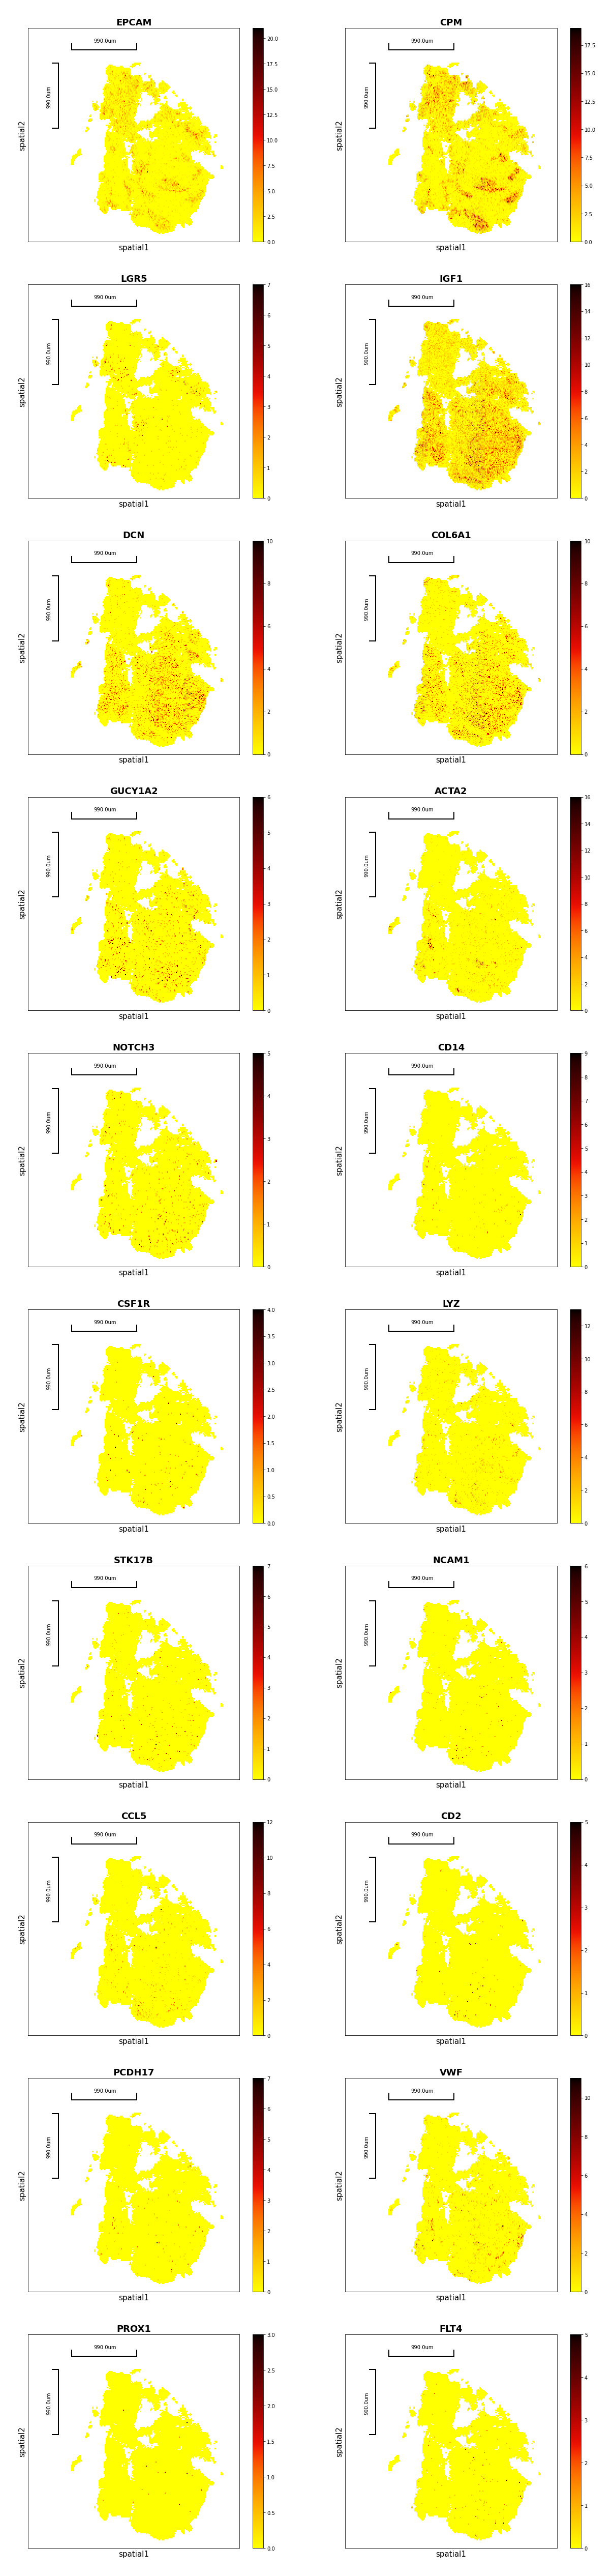

In [98]:
info = help(data.plt.spatial_scatter_by_gene)
print(info)

data.plt.spatial_scatter_by_gene(gene_name=all_marker_genes)

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

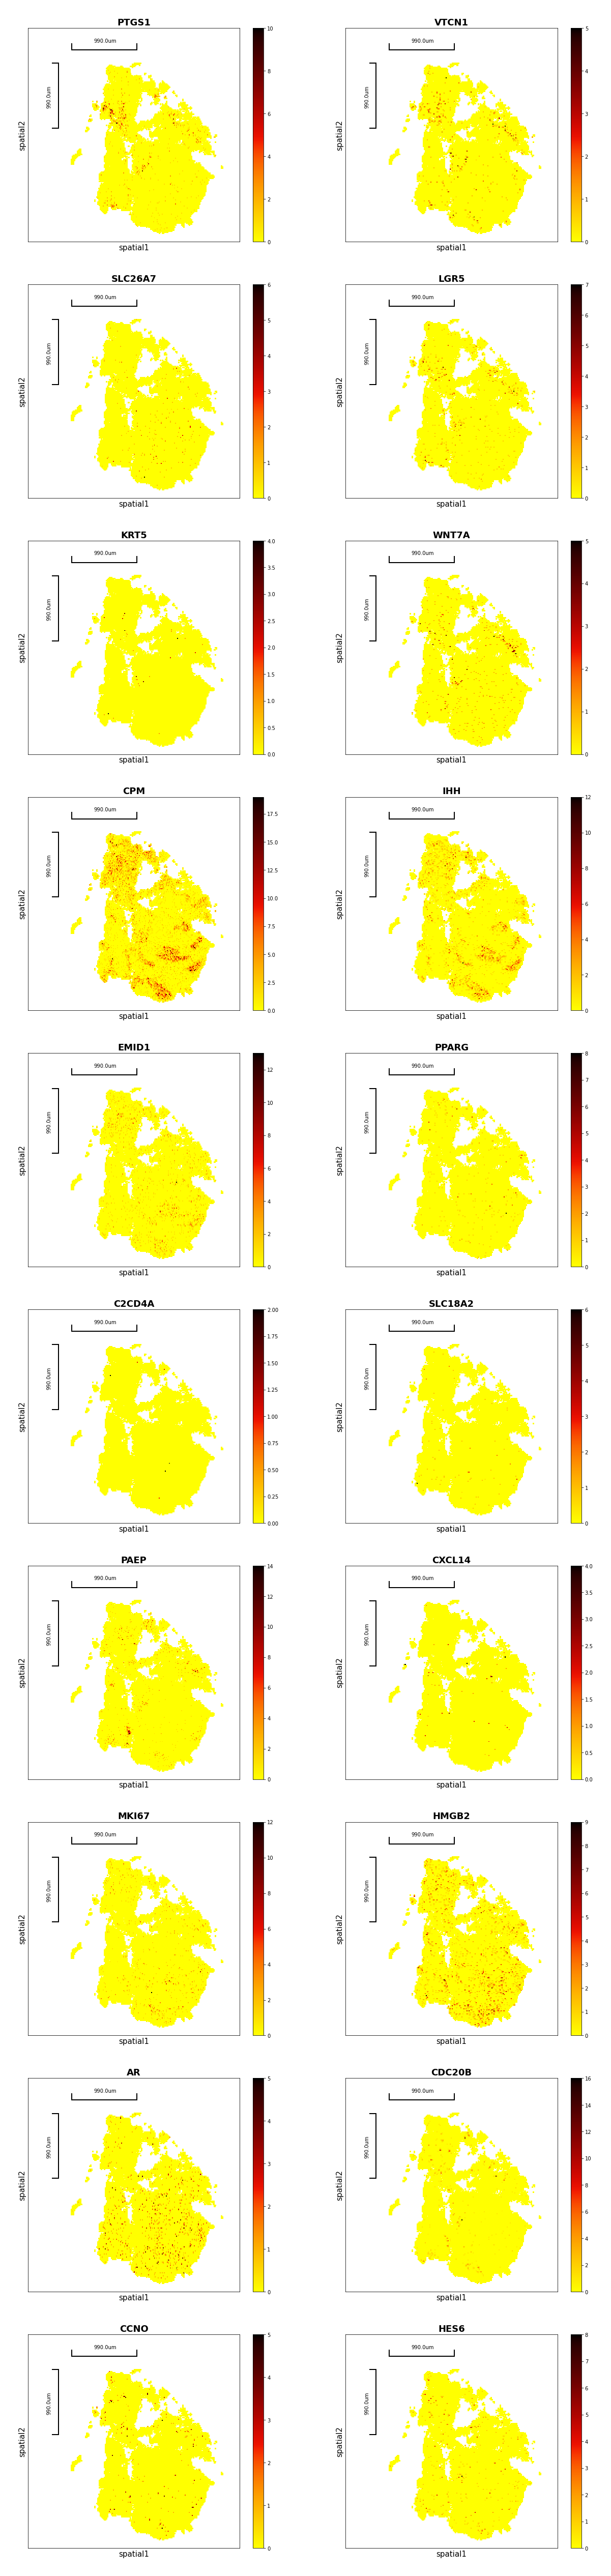

In [99]:
data.plt.spatial_scatter_by_gene(gene_name=epithelium_subtype)

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

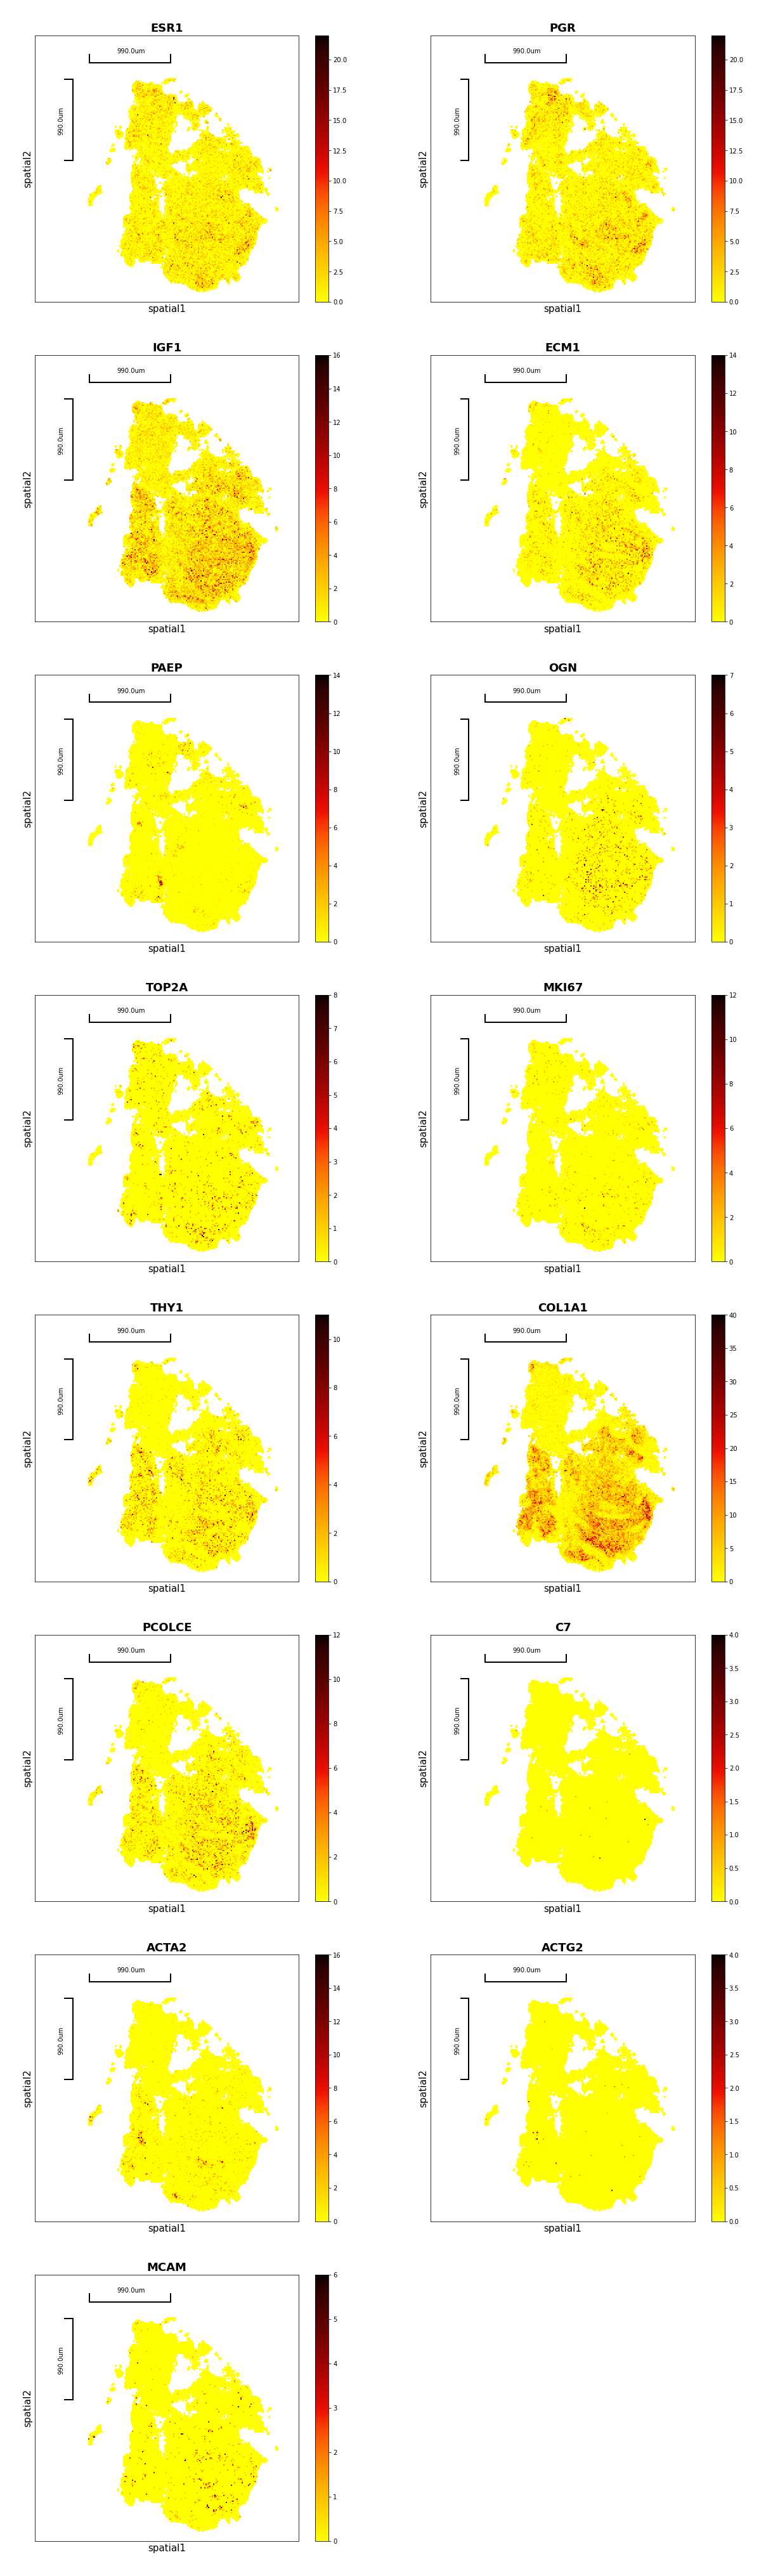

In [100]:
data.plt.spatial_scatter_by_gene(gene_name=stroma_subtype)

## Identify highly variable genes
We identify highly variable genes in the bins with their parameters and plot:

[2024-04-30 15:02:02][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-04-30 15:02:03][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.2993s.


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

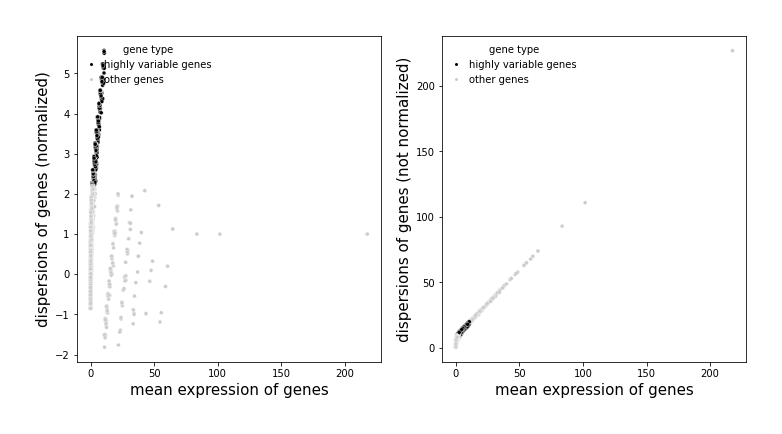

In [101]:
data.tl.highly_variable_genes(
        min_mean=0.0125,
        max_mean=3,
        min_disp=0.5,
        n_top_genes=2000,
        res_key='highly_variable_genes'
        )
data.plt.highly_variable_genes(res_key='highly_variable_genes')


The gene count is scaled.

In [102]:
data.tl.scale(max_value=10, zero_center=True)

[2024-04-30 15:02:15][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run scale...
[2024-04-30 15:02:23][Stereo][627410][MainThread][140223960068480][scale][53][INFO]: Truncate at max_value 10
[2024-04-30 15:02:24][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: scale end, consume time 8.9203s.


## Spatial hotspots

In [103]:
info = help(data.tl.spatial_hotspot)
print(info)
data.tl.spatial_hotspot(
                    use_highly_genes=True,
                    use_raw=True,
                    hvg_res_key='highly_variable_genes',
                    model='normal',
                    n_neighbors=30,
                    n_jobs=20,
                    fdr_threshold=0.05,
                    min_gene_threshold=10,
                    res_key='spatial_hotspot',
                    )

[2024-04-30 15:02:27][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run spatial_hotspot...


Help on method spatial_hotspot in module stereo.core.st_pipeline:

spatial_hotspot(use_highly_genes: bool = True, hvg_res_key: Union[str, NoneType] = 'highly_variable_genes', model: typing_extensions.Literal['danb', 'bernoilli', 'normal', 'none'] = 'normal', n_neighbors: int = 30, n_jobs: int = 20, fdr_threshold: float = 0.05, min_gene_threshold: int = 10, outdir: str = None, res_key: str = 'spatial_hotspot', use_raw: bool = True) method of stereo.core.st_pipeline.StPipeline instance
    Identify informative genes or gene modules.
    
    :param use_highly_genes: whether to use only the expression of hypervariable genes as input, default True.
    :param hvg_res_key: the key of highly variable genes to get corresponding result.
    :param model: specify the null model on gene expression from below:
                    `'danb'`: Depth-Adjusted Negative Binomial
                    `'bernoulli'`: Models probability of detection
                    `'normal'`: Depth-Adjusted Normal
     

[2024-04-30 15:02:27][Stereo][627410][MainThread][140223960068480][spatial_hotspot][50][INFO]: create the Hotspot object with 2000 genes and 12472 cells, model=normal.
[2024-04-30 15:02:27][Stereo][627410][MainThread][140223960068480][spatial_hotspot][52][INFO]: create_knn_graph with n_neighbors=30.
[2024-04-30 15:02:28][Stereo][627410][MainThread][140223960068480][spatial_hotspot][56][INFO]: Start compute_autocorrelations.
100%|███████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 46.99it/s]
[2024-04-30 15:03:13][Stereo][627410][MainThread][140223960068480][spatial_hotspot][60][INFO]: Remain 876 genes whose FDR < 0.05.
[2024-04-30 15:03:13][Stereo][627410][MainThread][140223960068480][spatial_hotspot][62][INFO]: Start compute_local_correlations.


Computing pair-wise local correlation on 876 features...


100%|████████████████████████████████████████████████████████████████████████████████████| 383250/383250 [00:12<00:00, 31582.39it/s]
[2024-04-30 15:03:29][Stereo][627410][MainThread][140223960068480][spatial_hotspot][64][INFO]: Start create_modules with min_gene_threshold=10, fdr_threshold=0.05.
[2024-04-30 15:03:29][Stereo][627410][MainThread][140223960068480][spatial_hotspot][68][INFO]: Start calculate_module_scores in per cell.


Computing scores for 11 modules...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.42it/s]
[2024-04-30 15:03:31][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: spatial_hotspot end, consume time 64.5384s.


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

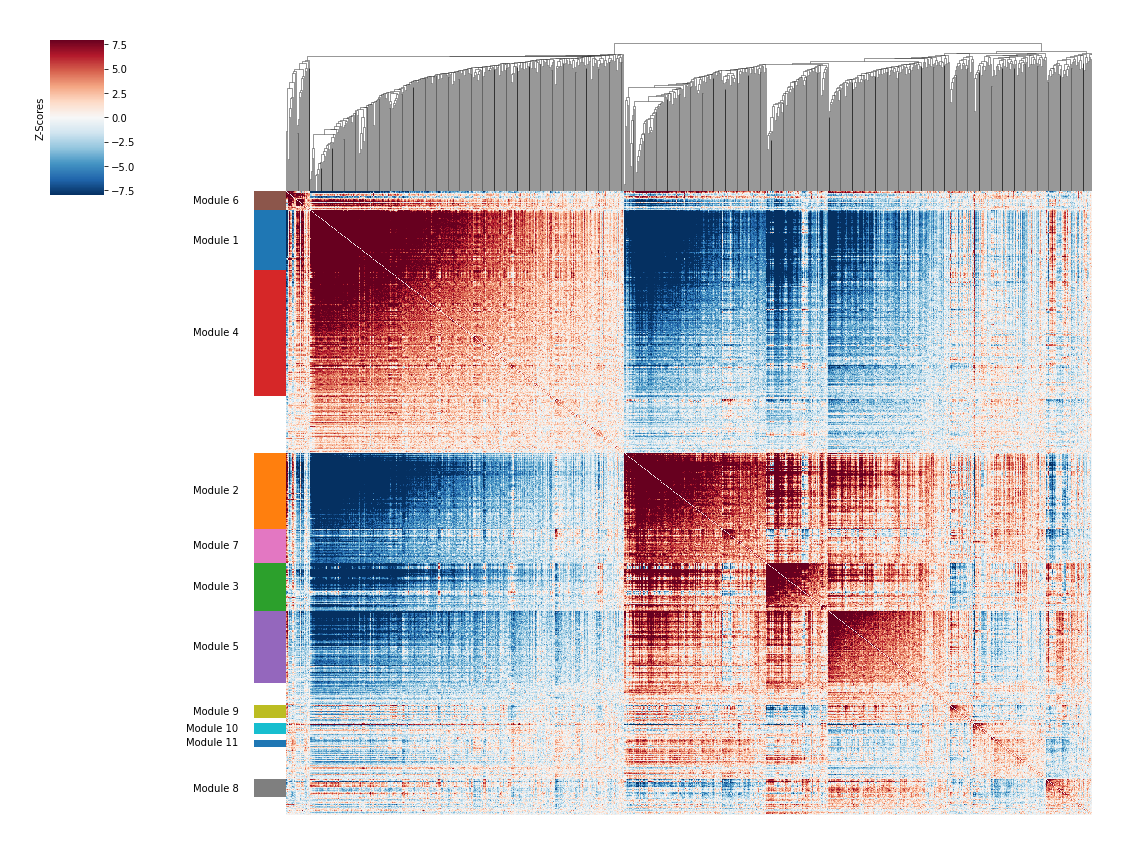

In [104]:
data.plt.hotspot_local_correlations()

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

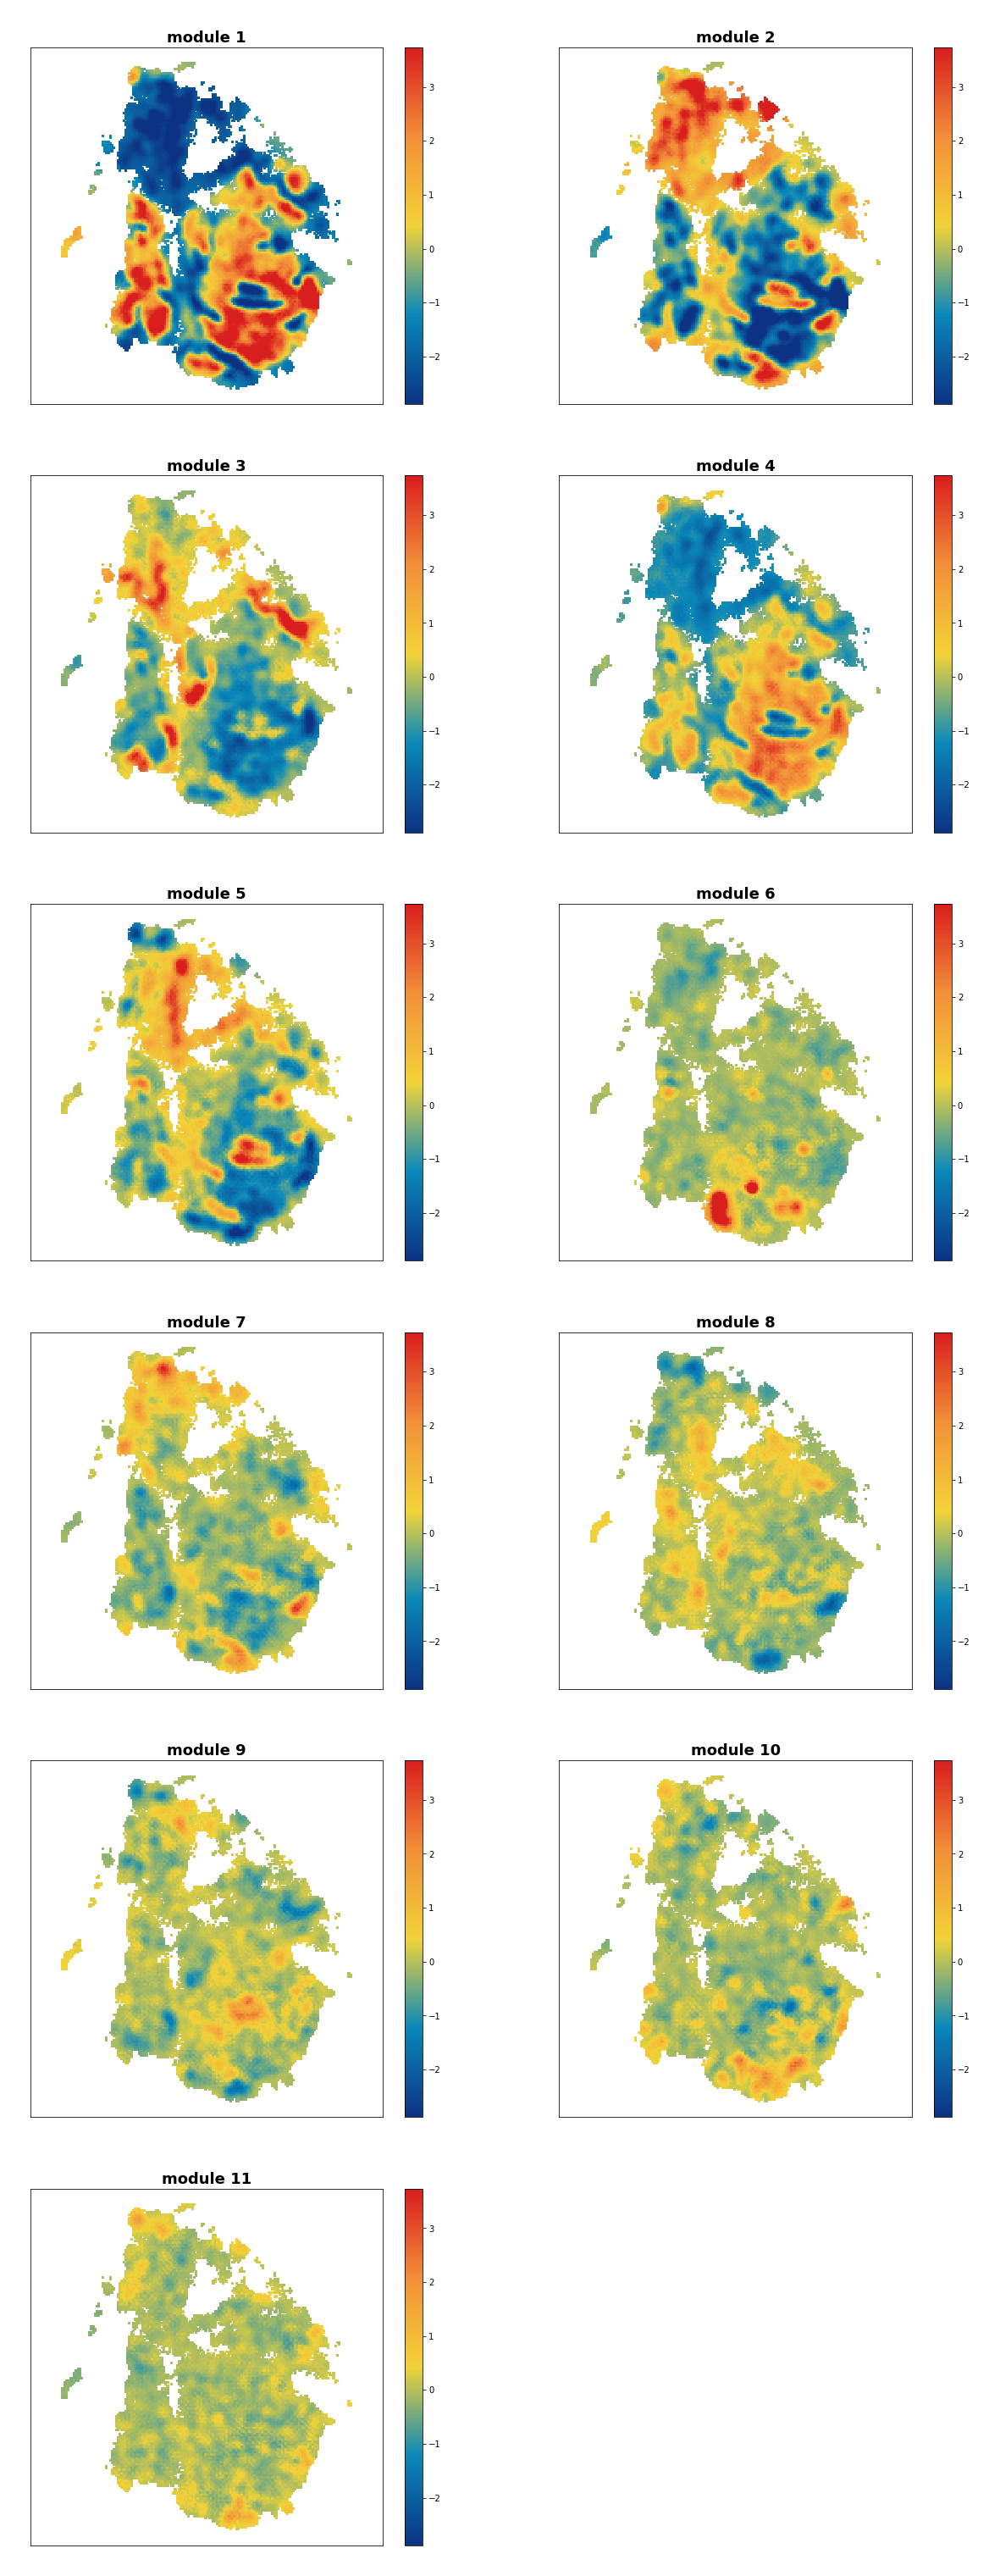

In [105]:
data.plt.hotspot_modules()

Extract the results of the modules

In [106]:
data.tl.result['spatial_hotspot']
data.tl.result['spatial_hotspot'].modules

SLC26A2    2
CXCL10     6
SCGB1D2    2
LUM        1
TGFBI      1
          ..
COX5A      7
GSTO1      5
CLTC      -1
HOXB5      7
LSM7       5
Name: Module, Length: 876, dtype: int64

## Leiden clustering
STOmics and Stereopy default output is in Leiden and is therefore used for clustering:

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

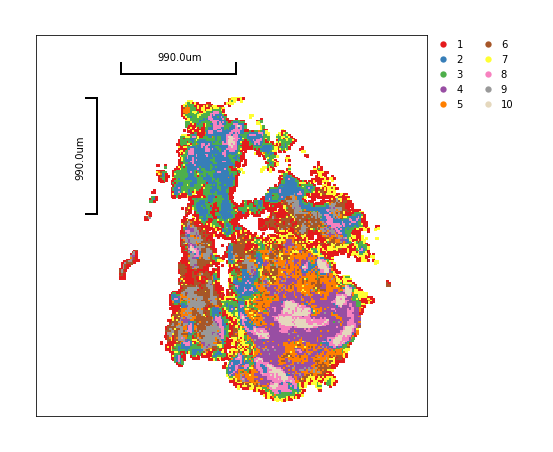

In [107]:
data.plt.cluster_scatter(res_key='leiden')

We can perform partial clustering on the data, focusing on certain groups.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

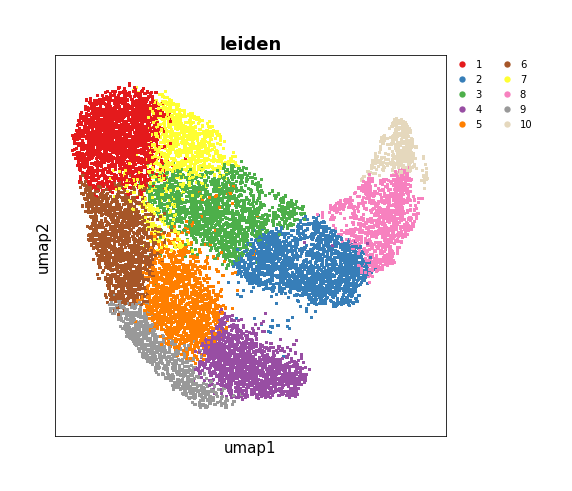

In [108]:
data.plt.umap(res_key='umap', cluster_key='leiden')

In Jupyter, we can interact with the plot:

In [109]:
data.plt.interact_cluster(res_key='leiden')

Row
    [0] ParamFunction(function, _pane=HoloViews)
    [1] Column
        [0] ColorPicker(name='background color', value='#ffffff', width=200)
        [1] IntSlider(end=200, name='dot size', start=1, value=8, width=200)
        [2] Select(name='color theme', options=['diverging_isoluminant_cj...], value='stereo_30', width=200)
        [3] Row
            [0] Select(name='cluster', options=['1', '2', '3', ...], value='1', width=100)
            [1] ColorPicker(name='node color', value='#E41A1C', width=70)

We can also display the spatial neighbors

In [110]:
#data.tl.leiden(neighbors_res_key='spatial_neighbors', res_key='spatial_leiden')

In [111]:
#data.plt.cluster_scatter(res_key='spatial_leiden')

## Louvain clustering
We test Louvain clustering. To reduce the object size, we do not perform it.

In [112]:
data.tl.louvain(neighbors_res_key='neighbors', res_key='louvain')

[2024-04-30 15:04:31][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run louvain...
[2024-04-30 15:04:31][Stereo][627410][MainThread][140223960068480][_louvain][109][INFO]:     using the "louvain" package of Traag (2017)
[2024-04-30 15:04:32][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: louvain end, consume time 0.9468s.


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

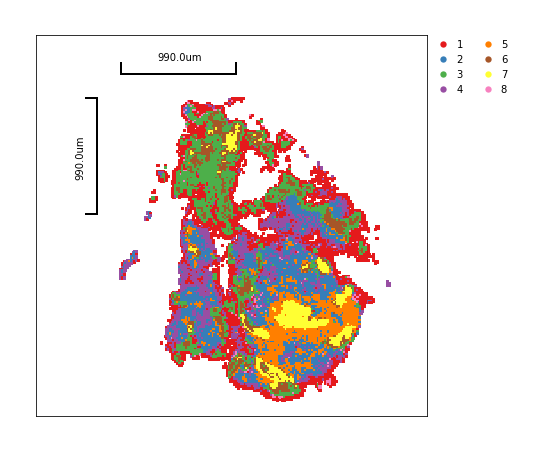

In [113]:
data.plt.cluster_scatter(res_key='louvain')

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

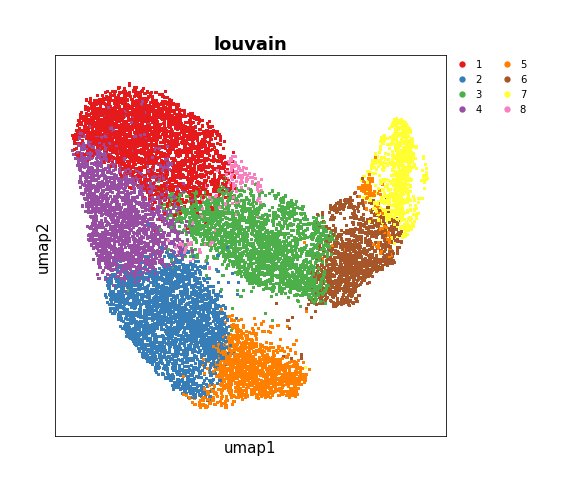

In [114]:
data.plt.umap(res_key='umap', cluster_key='louvain')

## Phenograph clustering
We test phenograph clustering. To reduce the object size, we do not perform it.

In [115]:
#data.tl.phenograph(phenograph_k=30, pca_res_key='pca', res_key='phenograph')

In [116]:
#data.plt.cluster_scatter(res_key='phenograph')

## Find Marker Genes
Using the Leiden clustering, we can check for marker genes as in Seurat. Default setting is t_test but we change to wilcoxon_test to match Seurat.

In [117]:
info = help(data.tl.find_marker_genes)
print(info)

data.tl.find_marker_genes(
        cluster_res_key='leiden',
        method='wilcoxon_test',
        use_highly_genes=False,
        use_raw=True
        )

[2024-04-30 15:04:51][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run find_marker_genes...
[2024-04-30 15:04:51][Stereo][627410][MainThread][140223960068480][tool_base][122][INFO]: read group information, grouping by group column.
[2024-04-30 15:04:51][Stereo][627410][MainThread][140223960068480][tool_base][151][INFO]: start to run...


Help on method find_marker_genes in module stereo.core.st_pipeline:

find_marker_genes(cluster_res_key, method: typing_extensions.Literal['t_test', 'wilcoxon_test'] = 't_test', case_groups: Union[str, numpy.ndarray, list] = 'all', control_groups: Union[str, numpy.ndarray, list] = 'rest', corr_method: str = 'benjamini-hochberg', use_raw: bool = True, use_highly_genes: bool = True, hvg_res_key: Union[str, NoneType] = 'highly_variable_genes', res_key: str = 'marker_genes', output: Union[str, NoneType] = None, sort_by='scores', n_genes: Union[str, int] = 'all', ascending: bool = False, n_jobs: int = 4) method of stereo.core.st_pipeline.StPipeline instance
    A tool to find maker genes. For each group, find statistical test different genes
    between one group and the rest groups using `t_test` or `wilcoxon_test`.
    
    :param cluster_res_key: the key of clustering to get corresponding result from `self.result`.
    :param method: choose method for statistics.
    :param case_groups: c

[2024-04-30 15:04:51][Stereo][627410][MainThread][140223960068480][find_markers][207][INFO]: cal rankdata
[2024-04-30 15:05:05][Stereo][627410][MainThread][140223960068480][find_markers][209][INFO]: cal tie_term
[2024-04-30 15:05:05][Stereo][627410][MainThread][140223960068480][find_markers][212][INFO]: cal tie_term end
[2024-04-30 15:05:05][Stereo][627410][MainThread][140223960068480][time_consume][57][INFO]: start to run calc_pct_and_pct_rest...
[2024-04-30 15:05:08][Stereo][627410][MainThread][140223960068480][time_consume][60][INFO]: calc_pct_and_pct_rest end, consume time 3.1544s.
[2024-04-30 15:06:18][Stereo][627410][MainThread][140223960068480][tool_base][153][INFO]: end to run.
[2024-04-30 15:06:18][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: find_marker_genes end, consume time 87.3602s.


Plot the marker genes found above.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

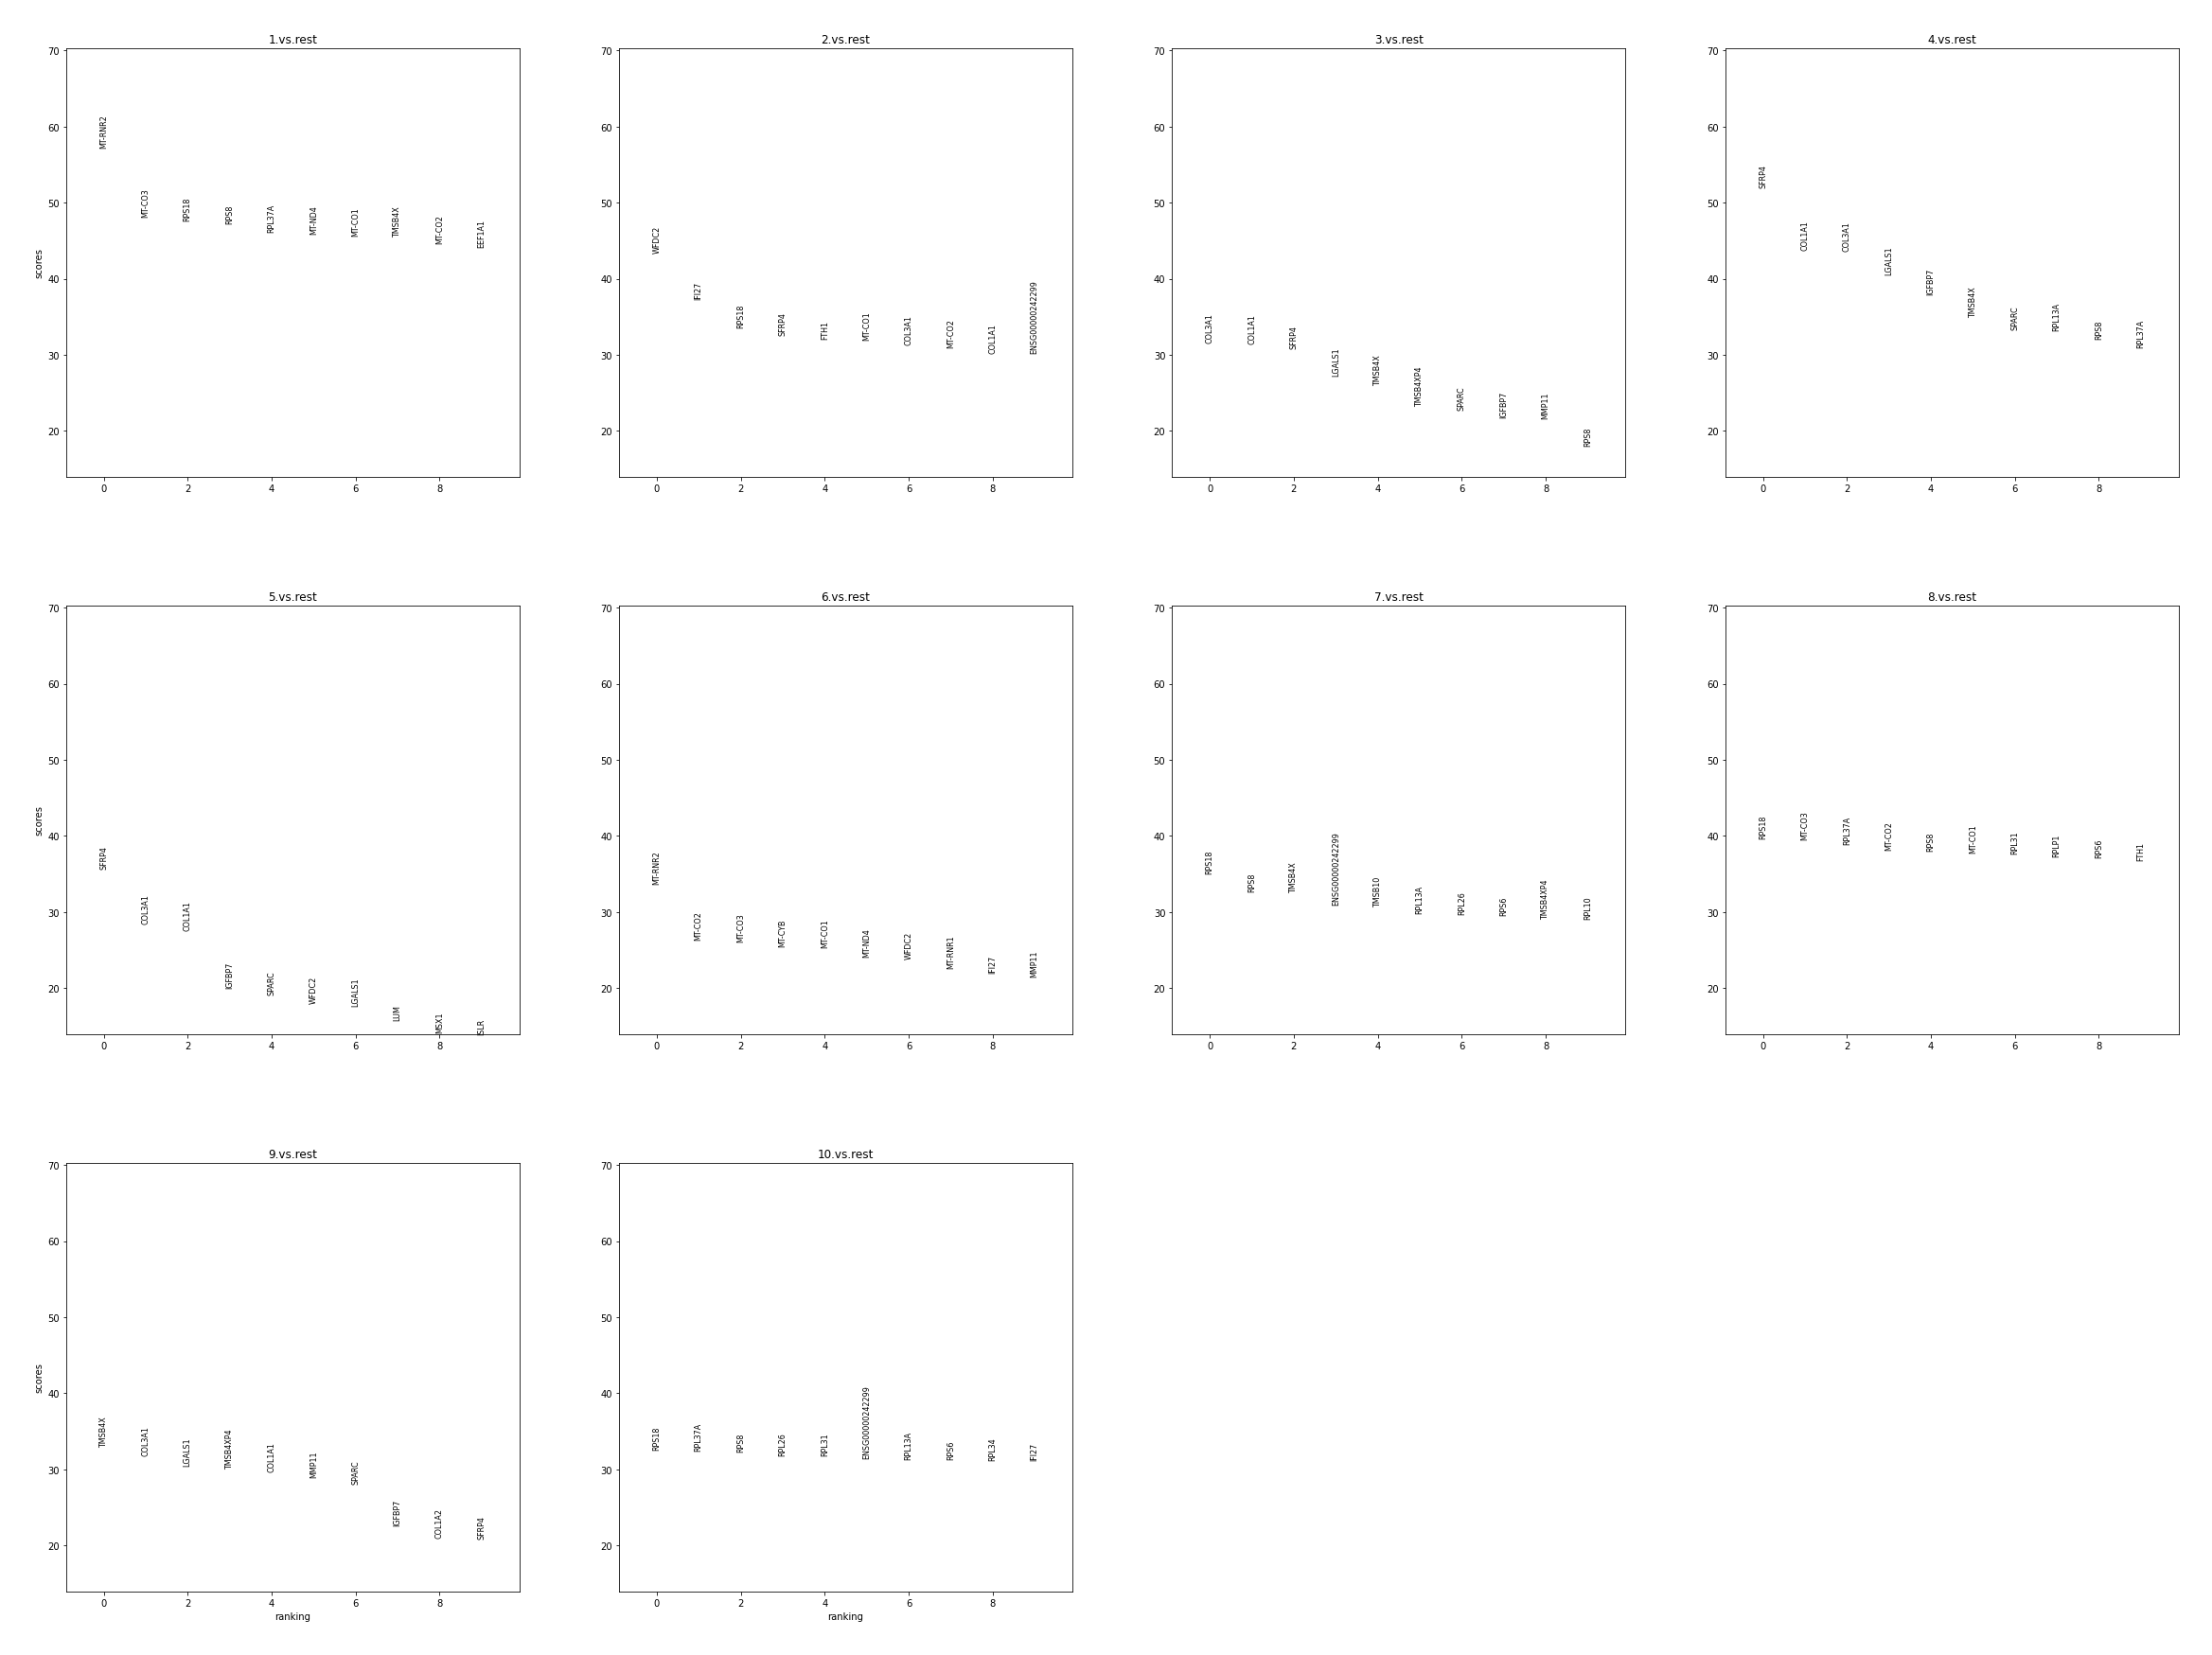

In [118]:
data.plt.marker_genes_text(
        res_key='marker_genes',
        markers_num=10,
        sort_key='scores'
        )

We can generate a dotplot of the data with the top 5 marker genes

Help on method marker_genes_scatter in module stereo.plots.plot_collection:

marker_genes_scatter(res_key: str, markers_num: Union[int, NoneType] = 10, genes: Union[Sequence[str], NoneType] = None, groups: Union[Sequence[str], NoneType] = None, values_to_plot: Union[Literal['scores', 'logfoldchanges', 'pvalues', 'pvalues_adj', 'log10_pvalues', 'log10_pvalues_adj'], NoneType] = None, sort_by: Literal['scores', 'logfoldchanges', 'pvalues', 'pvalues_adj'] = 'scores', width: Union[int, NoneType] = None, height: Union[int, NoneType] = None) method of stereo.plots.plot_collection.PlotCollection instance
    Scatter of marker genes
    
    :param res_key: results key, defaults to 'marker_genes'.
    :param markers_num: top N makers, defaults to 10.
    :param genes: name of genes which would be shown on plot, markers_num is ignored if it is set, defaults to None.
    :param groups: cell types which would be shown on plot, all cell types would be shown if set it to None, defaults to None.
   

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

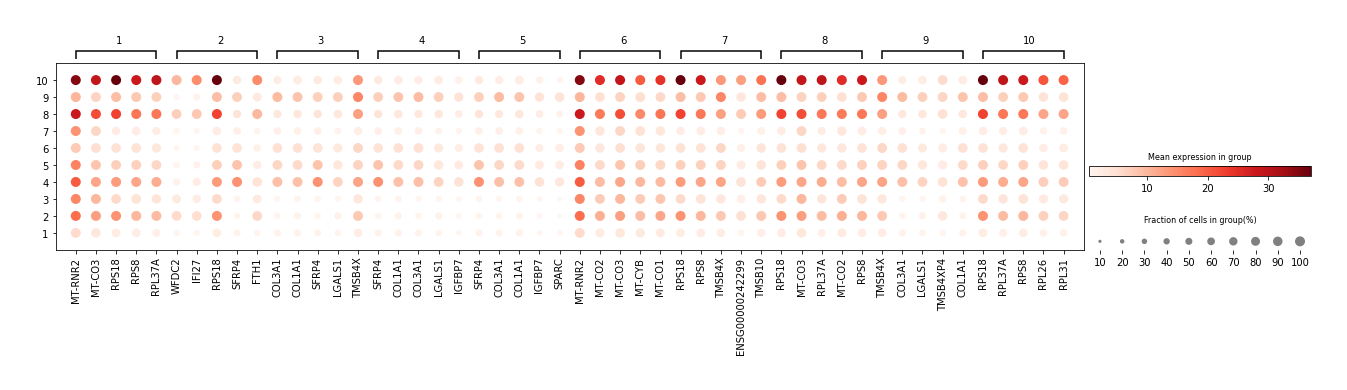

In [119]:
info = help(data.plt.marker_genes_scatter)
print(info)
data.plt.marker_genes_scatter(res_key='marker_genes', markers_num=5)

## Save the data before annotation
Saving the data before annotation with the flavor set to Seurat, allowing for analysis in R with Seurat. 

In [120]:
#adata = st.io.stereo_to_anndata(data, flavor='seurat', output='./Output/0_Preprocessing_bin30_filtered_SCT/Filename_bin30_SCT.h5ad')
st.io.write_h5ad(data, output=output_SCT)

[2024-04-30 15:06:24][Stereo][627410][MainThread][140223960068480][data][73][WARNING]: the output file is exists, we will replace it with new file.


## Cell type annotation
With the marker genes, we can annotate the object.

In [121]:
info = help(data.plt.marker_genes_scatter)
print(info)

Help on method marker_genes_scatter in module stereo.plots.plot_collection:

marker_genes_scatter(res_key: str, markers_num: Union[int, NoneType] = 10, genes: Union[Sequence[str], NoneType] = None, groups: Union[Sequence[str], NoneType] = None, values_to_plot: Union[Literal['scores', 'logfoldchanges', 'pvalues', 'pvalues_adj', 'log10_pvalues', 'log10_pvalues_adj'], NoneType] = None, sort_by: Literal['scores', 'logfoldchanges', 'pvalues', 'pvalues_adj'] = 'scores', width: Union[int, NoneType] = None, height: Union[int, NoneType] = None) method of stereo.plots.plot_collection.PlotCollection instance
    Scatter of marker genes
    
    :param res_key: results key, defaults to 'marker_genes'.
    :param markers_num: top N makers, defaults to 10.
    :param genes: name of genes which would be shown on plot, markers_num is ignored if it is set, defaults to None.
    :param groups: cell types which would be shown on plot, all cell types would be shown if set it to None, defaults to None.
   

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

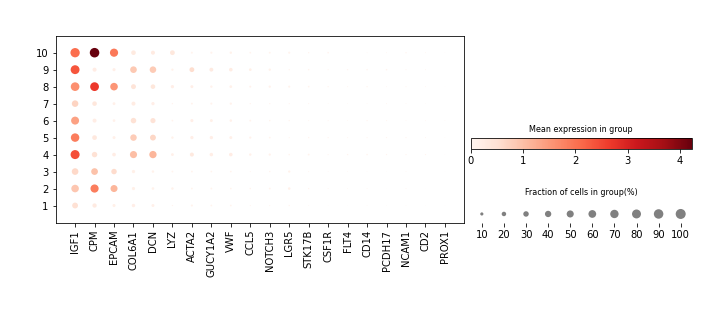

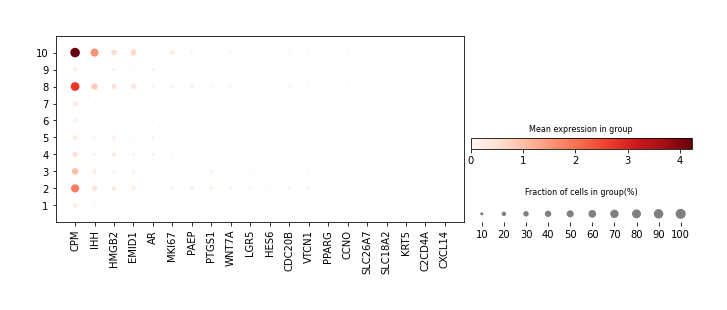

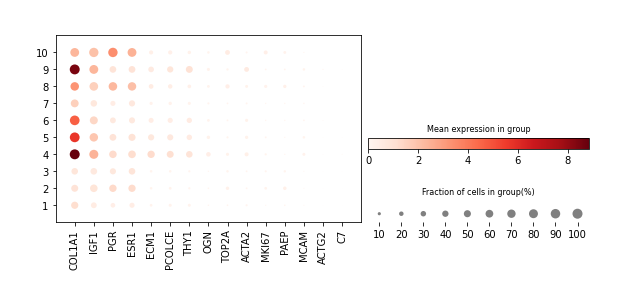

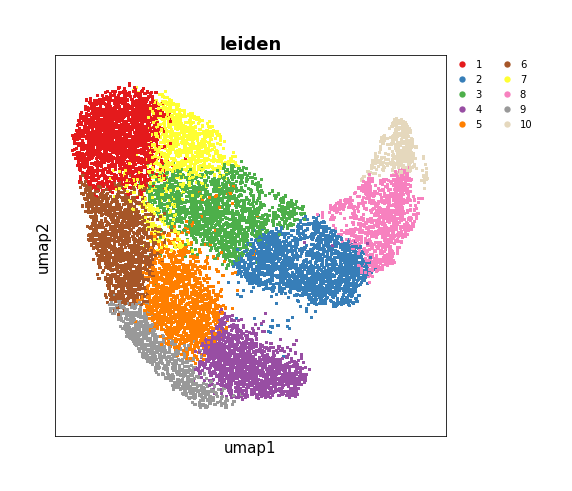

In [122]:
data.plt.marker_genes_scatter(res_key='marker_genes', genes=all_marker_genes)
data.plt.marker_genes_scatter(res_key='marker_genes', genes=epithelium_subtype)
data.plt.marker_genes_scatter(res_key='marker_genes', genes=stroma_subtype)
data.plt.umap(res_key='umap', cluster_key='leiden')

We can add the annotation data in a seperate vector:

In [123]:
annotation_dict = {
    '1':'Undefined', '2':'Epithelium',
    '3':'Epithelium', '4':'Stroma',
    '5':'Stroma', '6':'Stroma',
    '7':'Undefined', '8':'Epithelium',
    '9':'Stroma', '10':'Epithelium'}

In [124]:
data.plt.interact_annotation_cluster(
            res_cluster_key='leiden',
            res_marker_gene_key='marker_genes',
            res_key='leiden_annotation'
            )

Row
    [0] ParamFunction(function, _pane=HoloViews)
    [1] Column
        [0] IntSlider(end=200, name='dot size', start=1, value=8, width=200)
        [1] Row
            [0] Select(name='cluster', options=['1', '2', '3', ...], value='1', width=100)
            [1] TextInput(name='annotation', width=100)
        [2] Button(name='Save annotation', width=200)
        [3] ParamFunction(function, _pane=DataFrame)

In [125]:
data.tl.annotation(
        annotation_information=annotation_dict,
        cluster_res_key='leiden',
        res_key='anno_leiden'
        )

[2024-04-30 15:12:53][Stereo][627410][MainThread][140223960068480][st_pipeline][41][INFO]: start to run annotation...
[2024-04-30 15:12:54][Stereo][627410][MainThread][140223960068480][st_pipeline][44][INFO]: annotation end, consume time 0.1321s.


Plot the annotated data:

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

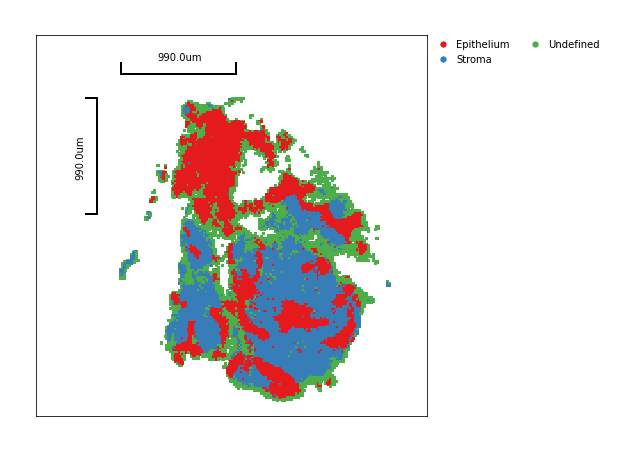

In [126]:
data.plt.cluster_scatter(res_key='anno_leiden')

## Saving to .h5ad
Transform the data to AnnData and save it as an .H5ad file which can later be transformed to .H5seurat for analysis in R in harmony with the 10x data.

In [127]:
adata = st.io.stereo_to_anndata(data, flavor = 'seurat', output=output_ann)

[2024-04-30 15:13:10][Stereo][627410][MainThread][140223960068480][reader][821][INFO]: Adding sample in adata.obs['orig.ident'].
[2024-04-30 15:13:10][Stereo][627410][MainThread][140223960068480][reader][824][INFO]: Adding data.position as adata.obsm['spatial'] .
[2024-04-30 15:13:10][Stereo][627410][MainThread][140223960068480][reader][829][INFO]: Adding data.position as adata.obs['x'] and adata.obs['y'] .
[2024-04-30 15:13:10][Stereo][627410][MainThread][140223960068480][reader][859][INFO]: Adding data.tl.result['highly_variable_genes'] into adata.var .
[2024-04-30 15:13:10][Stereo][627410][MainThread][140223960068480][reader][881][INFO]: Adding data.tl.result['pca'] into adata.obsm['X_pca'] .
[2024-04-30 15:13:10][Stereo][627410][MainThread][140223960068480][reader][889][INFO]: Adding data.tl.result['neighbors']['connectivities'] into adata.obsp['connectivities'] .
[2024-04-30 15:13:10][Stereo][627410][MainThread][140223960068480][reader][890][INFO]: Adding data.tl.result['neighbors